In [1]:
import lsst.daf.persistence as dafPersist
import matplotlib.pyplot as plt
import numpy as np

import lsst.afw.table as afwTable
import lsst.afw.geom as afwGeom
import Utils.DiaSourceTools as DSTools
from astropy.time import Time

import lsst.afw.display.ds9 as ds9

import re

import glob
from astropy.io import ascii

In [2]:
lienObj = glob.glob("/datadec/cppm/jpreyes/light_curves/*.dat")

lcs = []
for oj in lienObj:
    table = ascii.read(oj)
    lcs.append(table)
print len(lcs)

613640


This is the colour map. You can modify these values to change the light curve point colors.

In [3]:
stack_colors = {"sdssg":"green", "sdssi":"blue", "sdssr":"red", "sdssz":"magenta"}

snls_colors = {"sdssg":"darkgreen", "sdssi":"darkblue", "sdssr":"darkred", "sdssz":"purple"}

Loading of SNLS Data

In [4]:
def show_multi_filter_light_curve(t, colors, n_factor = None):

    t_by_filter = t.group_by("bandpass")

    indices = t_by_filter.groups.indices
    #print indices

    for i in range(0, len(indices)-1):

        data = t_by_filter[indices[i]:indices[i+1]]
        
        if n_factor is not None:
            value = n_factor[data[0]["bandpass"]]
            f = value if np.isnan(value) == False else 1
            plt.errorbar(data["mjd"], data["flux"]*f,yerr=data["flux_error"]*f, fmt='.', markersize='5', label=data[0]["bandpass"], c=colors[data[0]["bandpass"]])            
        else:
            plt.errorbar(data["mjd"], data["flux"],yerr=data["flux_error"], fmt='.', markersize='5', label=data[0]["bandpass"], c=colors[data[0]["bandpass"]])
    plt.legend()
    #plt.show()

3


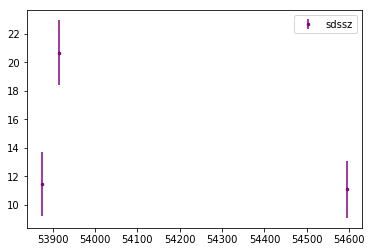

In [7]:
%matplotlib inline
lc = lcs[35000]
print len(lc)
show_multi_filter_light_curve(lc, snls_colors)
plt.show()

In [9]:
np.max(lc["mjd"])

54594.0

In [10]:
stats = []
multi_lc = []
time = []
for lc in lcs:
    t_by_filter = lc.group_by("bandpass")
    indices = t_by_filter.groups.indices
    if len(indices) > 2:
        multi_lc.append(lc)
        time.append(np.max(lc["mjd"])-np.min(lc["mjd"]))
    stats.append(len(indices)-1)

53


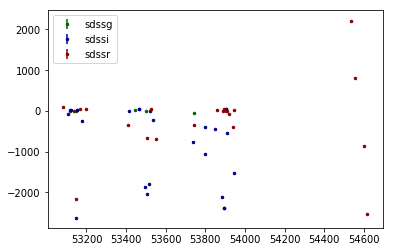

In [19]:

lc = multi_lc[5500]
print len(lc)
show_multi_filter_light_curve(lc, snls_colors)
plt.show()

(array([  1.47000000e+02,   3.40000000e+01,   1.15500000e+03,
          4.29000000e+02,   3.92100000e+03,   3.54200000e+03,
          1.42500000e+03,   3.10700000e+03,   2.90700000e+03,
          3.47130000e+04]),
 array([    7. ,   161.1,   315.2,   469.3,   623.4,   777.5,   931.6,
         1085.7,  1239.8,  1393.9,  1548. ]),
 <a list of 10 Patch objects>)

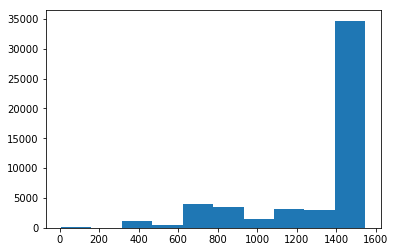

In [23]:
plt.hist(time)

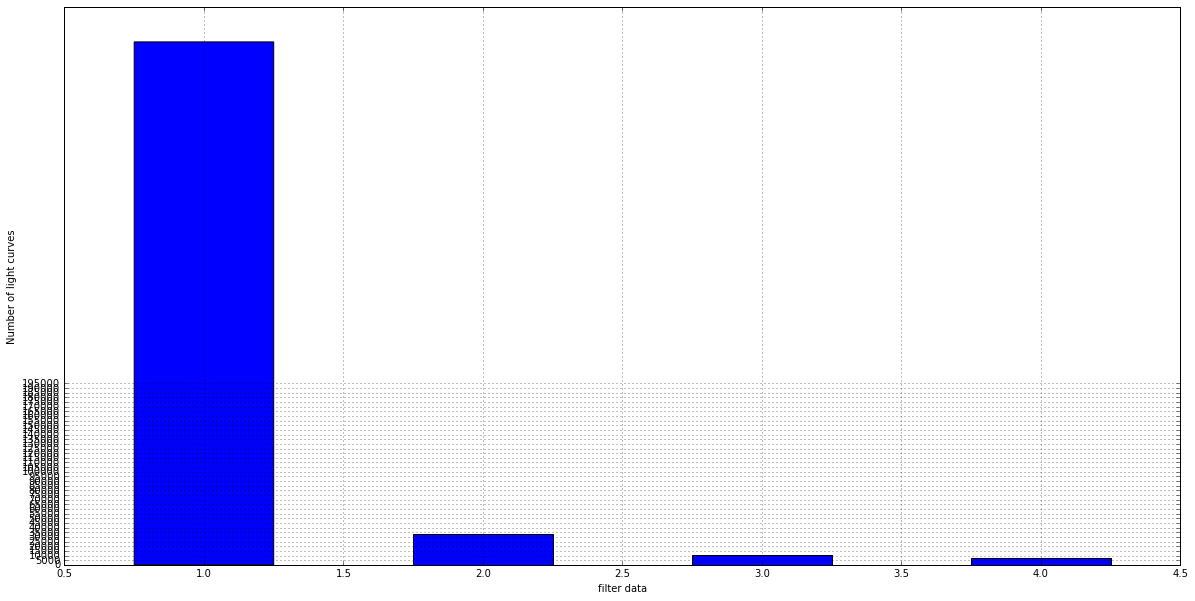

In [19]:
%matplotlib inline
plt.figure(figsize=(20,10))
plt.hist(stats, bins=range(1,6,1), align='left', rwidth=0.5)
plt.ylabel("Number of light curves")
plt.xlabel("filter data")
plt.yticks(np.arange(0,200000,5000))
plt.grid(True)
plt.show()

In [37]:
%matplotlib inline
import re
import astropy.coordinates as coord
import astropy.units as u


f = open('/renoir_data_02/jpreyes/lsst_data/sn_control/J_A+A_523_A7_table9.dat.txt','r')
data_elems = f.read()
elems = re.findall('^(04D3.*?)\\|(.*?)\\|', data_elems, re.MULTILINE)

f = open('/renoir_data_02/jpreyes/lsst_data/sn_control/J_A+A_523_A7_table10.dat.txt','r')
data = f.read()

snls_array = []
for sn in elems:
    c = coord.SkyCoord(sn[-1], unit=(u.hourangle, u.deg))
    
    m = re.findall('^'+str(sn[0])+'\\|(r|g|z|i)\\|(.*?)\\|(.*?)\\|(.*?)$', data, re.MULTILINE)

    snls_lc = DSTools.build_light_curve_from_snls_file(m, c)
    
    #print m
    print sn[0], c.ra.deg, c.dec.deg
    
    #plt.errorbar(snls_lc['mjd'], snls_lc['flux'], yerr=snls_lc['flux_error'], fmt='.', color='blue')
    #show_multi_filter_light_curve(snls_lc, snls_colors)
    #plt.show()
    snls_array.append(snls_lc)
    
print("total of sn:" + str(len(snls_array)))

04D3bf 214.437779167 52.4677916667
04D3co 214.458245833 52.9636111111
04D3cp 215.099658333 52.8209333333
04D3cy 214.551808333 52.6583305556
04D3dd 214.4516875 52.4706777778
04D3df 214.541670833 52.2776861111
04D3do 214.442008333 52.2675527778
04D3ez 214.782641667 53.0719472222
04D3fk 214.6091 52.5284666667
04D3fq 214.2411875 52.3794722222
04D3gt 215.635795833 52.6469222222
04D3gx 215.05695 52.2827777778
04D3hn 215.528729167 52.2285861111
04D3kr 214.149725 52.478875
04D3ks 215.639779167 52.1851833333
04D3lp 214.962120833 52.5031944444
04D3lu 215.283208333 52.9747916667
04D3mk 214.85735 53.1636944444
04D3ml 214.162783333 53.0932527778
04D3nc 214.0759125 52.2738027778
04D3nh 215.611283333 52.3334472222
04D3nq 215.079729167 53.1544138889
04D3nr 215.66045 52.6486861111
04D3ny 214.734666667 52.1874638889
04D3oe 214.9141 52.5538472222
total of sn:25


In [38]:
def match_with_lc(snls_array, stack_lc):
    matches = []
    for lc in snls_array:
        #print "light curve"
        val = {"ra":lc[0]["ra"], "dec":lc[0]["dec"]}
        #print np.rad2deg(lc[0]["ra"]), np.rad2deg(lc[0]["dec"])
        for i, slc in enumerate(stack_lc):

            comp = {"ra":np.mean(slc["ra"]), "dec":np.mean(slc["dec"])}
            if DSTools.source_distance(val, comp)<1:
                print i
                matches.append((lc,slc))


    print len(matches)
    return matches

In [39]:
len(snls_array)

25

In [40]:
matches_45= match_with_lc(snls_array, multi_lc)

36862
48280
5505
41773
36875
46372
12663
8063
11724
39904
29105
50544
44313
25368
41173
16878
19071
13898
17604
46034
40124
10037
29134
44883
31095
25


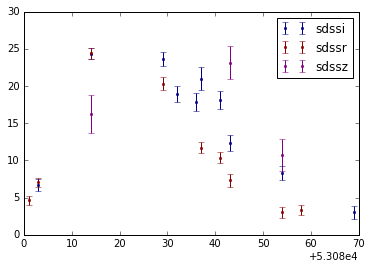

In [90]:
lc = lcs[53785]
show_multi_filter_light_curve(lc, snls_colors)

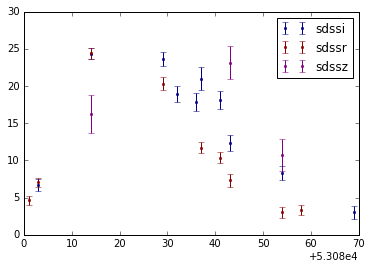

In [91]:
lc = lcs[57904]
show_multi_filter_light_curve(lc, snls_colors)

In [28]:
from scipy.stats import sigmaclip

def normalize_light_curve(lc1, lc2, filter):
   
    l1 = lc1[lc1['bandpass']==filter]
    l2 = lc2[lc2['bandpass']==filter]
    norm = []
    for row1 in l1:
        for row2 in l2:
            if int(row1["mjd"]) == int(row2["mjd"]):
                norm.append(row1["flux"]/row2["flux"])
                
    c_array = sigmaclip(norm, low=1.5, high=1.5)
    return c_array.clipped.mean()

214.291952598 53.024780659
{'sdssi': 26.397506721419525, 'sdssr': 19.337540002953133, 'sdssz': nan, 'sdssg': 17.624876027868396}


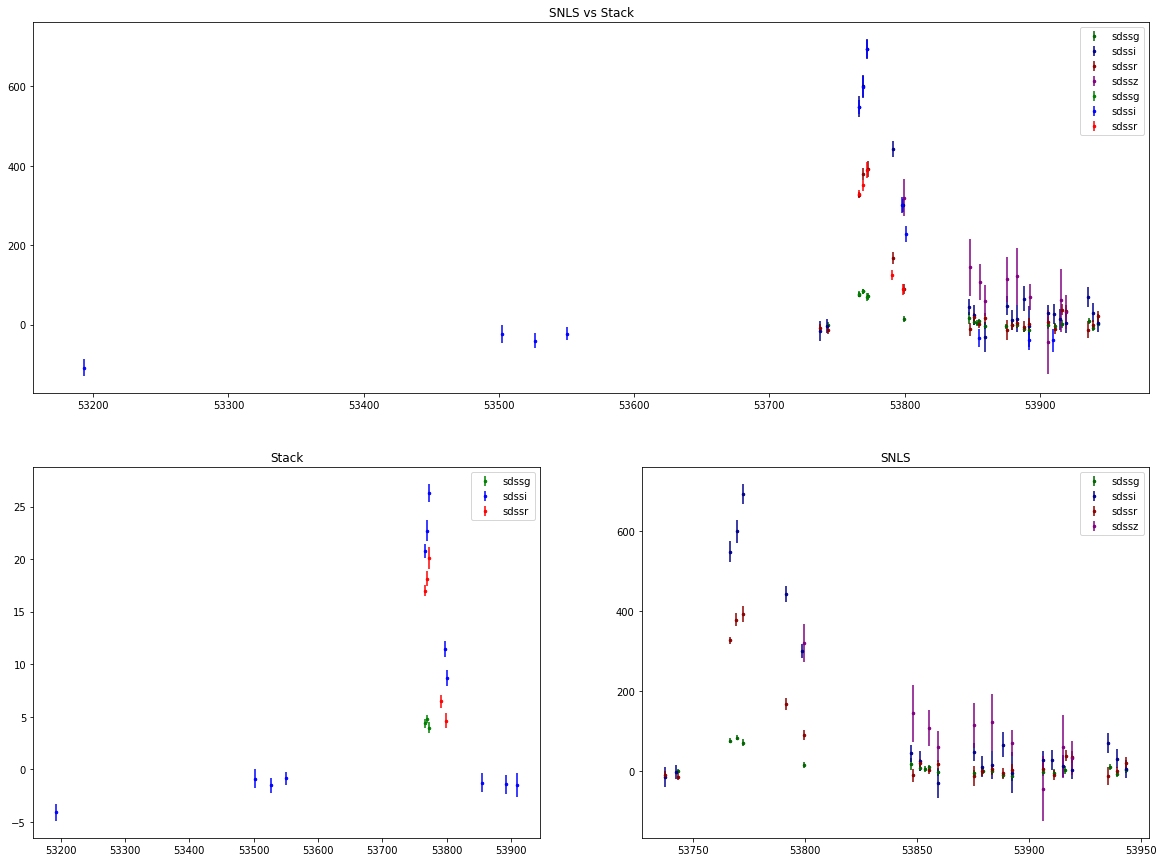

215.181548246 52.1910526282
{'sdssi': 4.294289947940169, 'sdssr': 21.58044334981528, 'sdssz': nan, 'sdssg': nan}


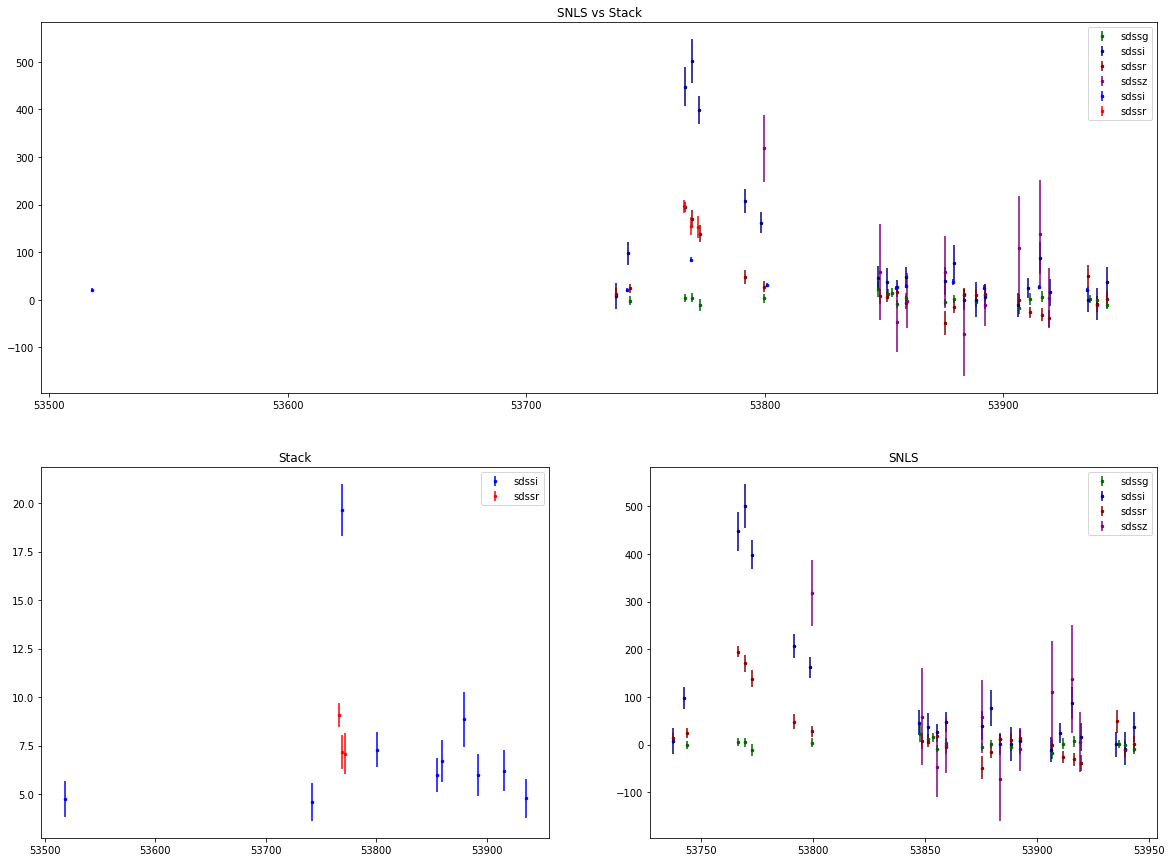

214.381724246 52.9123774522
{'sdssi': 26.015140122231557, 'sdssr': 22.187396064875252, 'sdssz': nan, 'sdssg': 11.873956047502338}


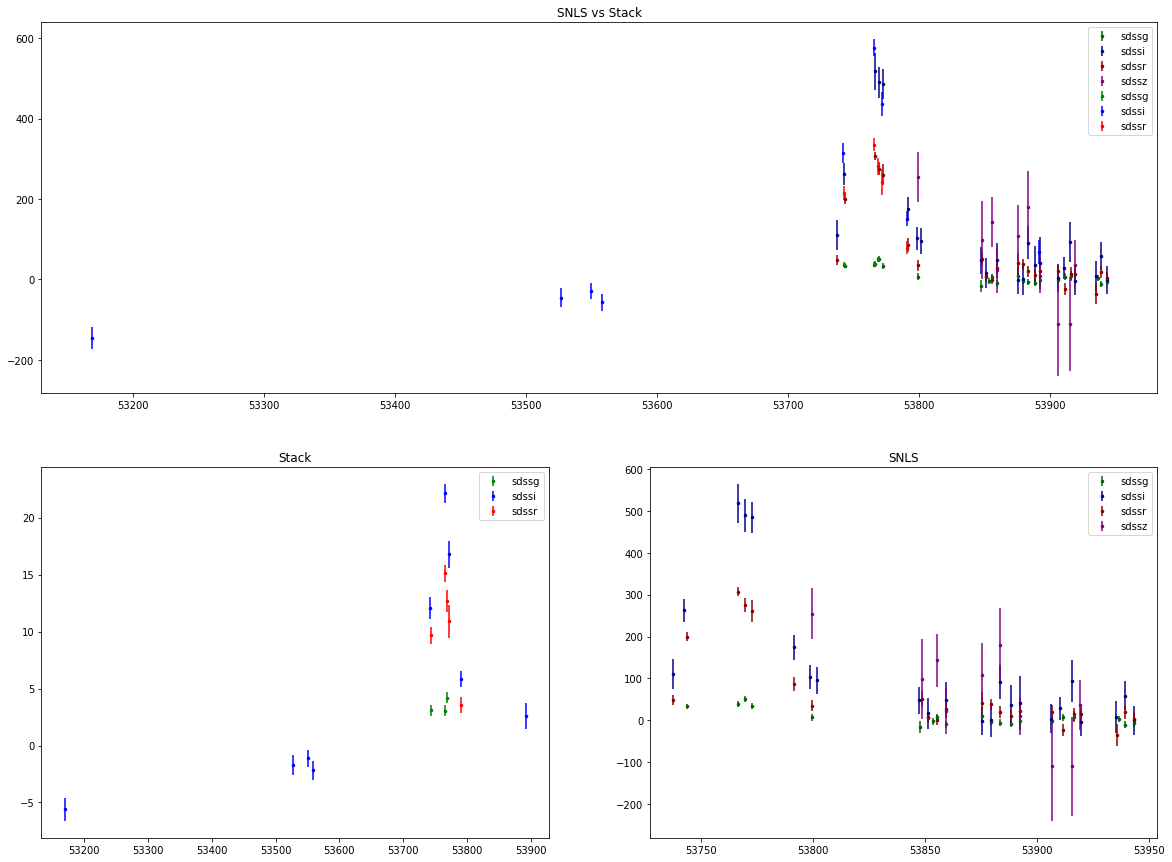

214.857571923 52.6410509191
{'sdssi': 27.864458859799672, 'sdssr': 19.362834542104853, 'sdssz': 31.845326148748864, 'sdssg': 17.077039929779847}


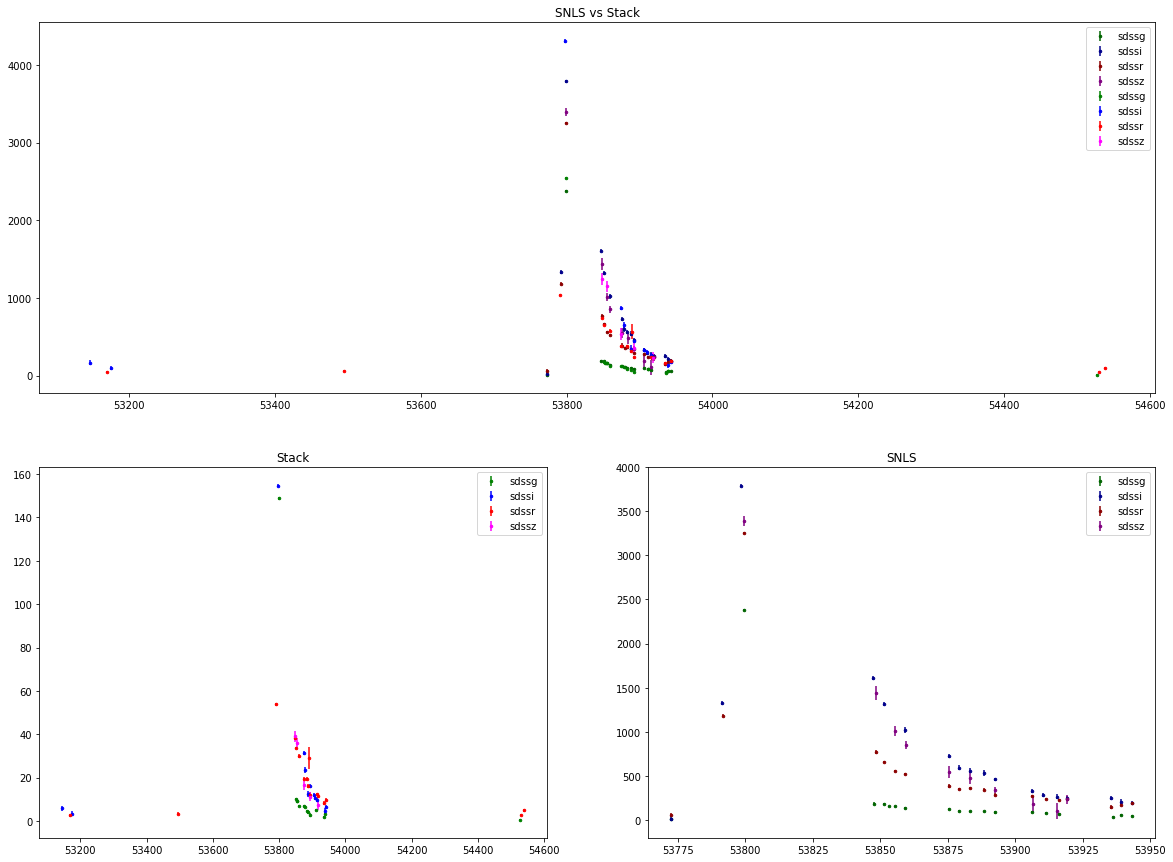

215.571965716 52.957719372
{'sdssi': 17.534345389495648, 'sdssr': nan, 'sdssz': 15.280578780321902, 'sdssg': 16.962078417139377}


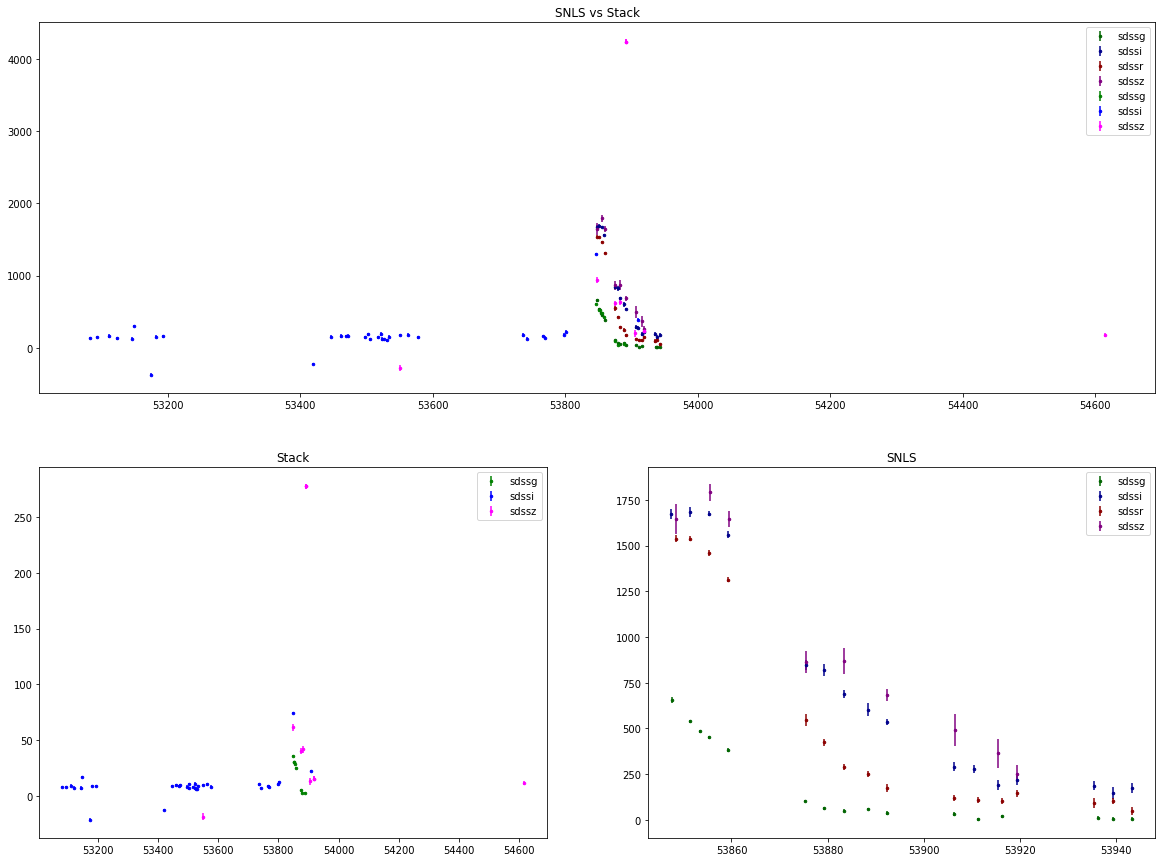

215.552322404 52.6408888658
{'sdssi': 22.612707068733663, 'sdssr': 20.60863643499885, 'sdssz': 26.656716049141306, 'sdssg': 16.596521692157356}


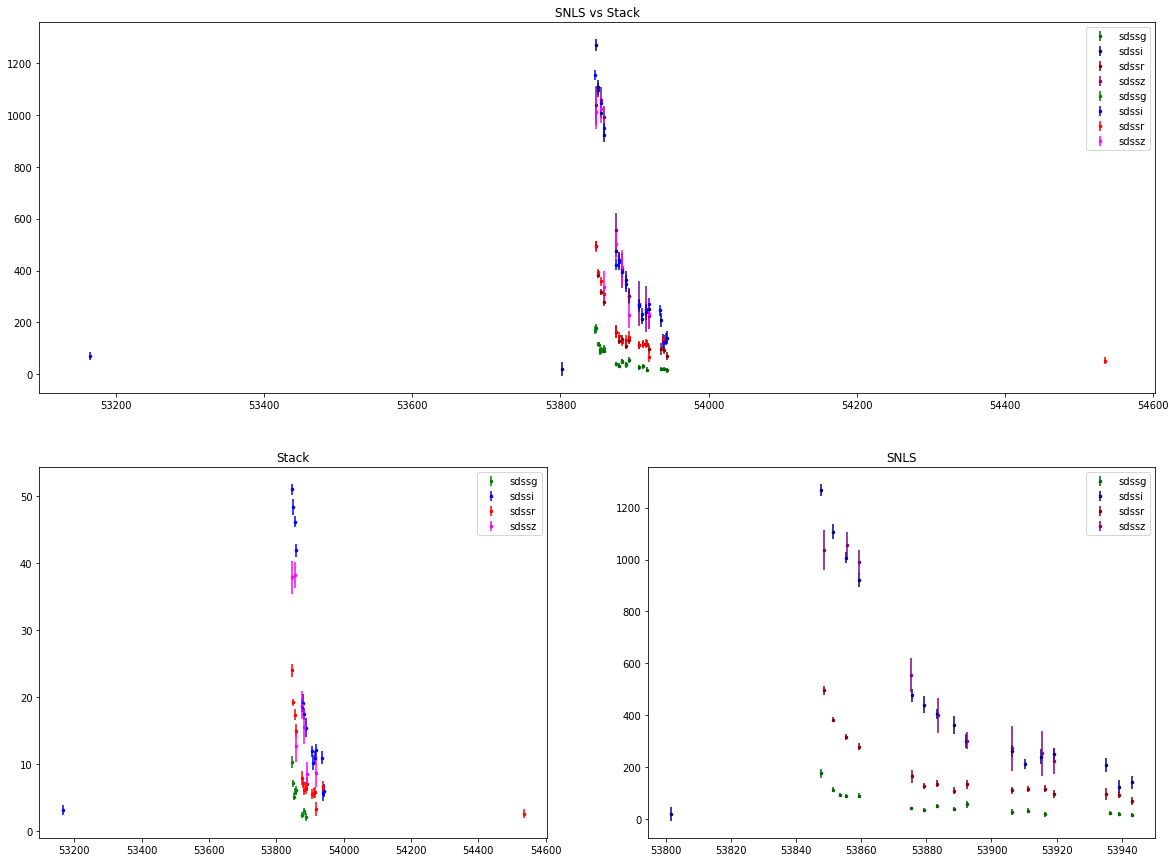

214.247547127 52.882489376
{'sdssi': 28.343102835613973, 'sdssr': 20.686819225596867, 'sdssz': 26.251308276226151, 'sdssg': 15.816326466962488}


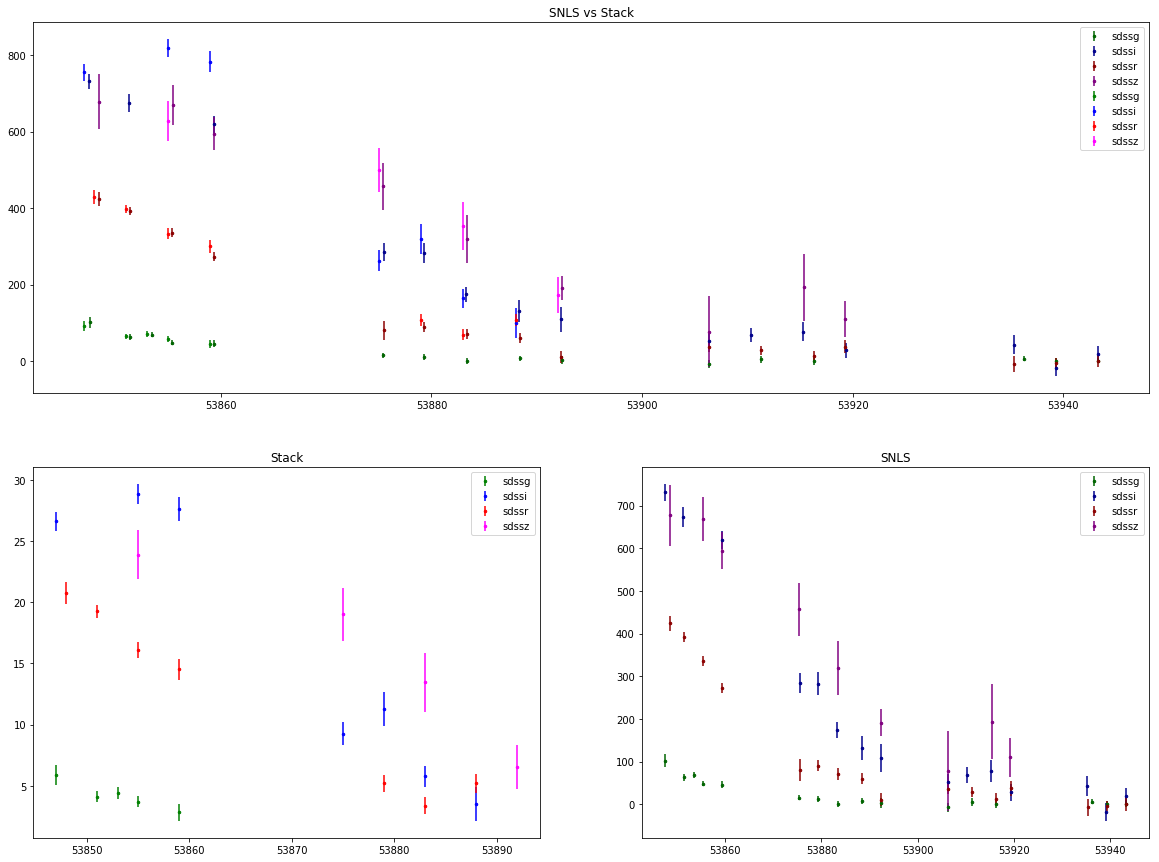

214.340227558 52.4527742691
{'sdssi': 24.446510415388818, 'sdssr': 18.963368180200341, 'sdssz': 24.048241376675392, 'sdssg': 15.047509964047626}


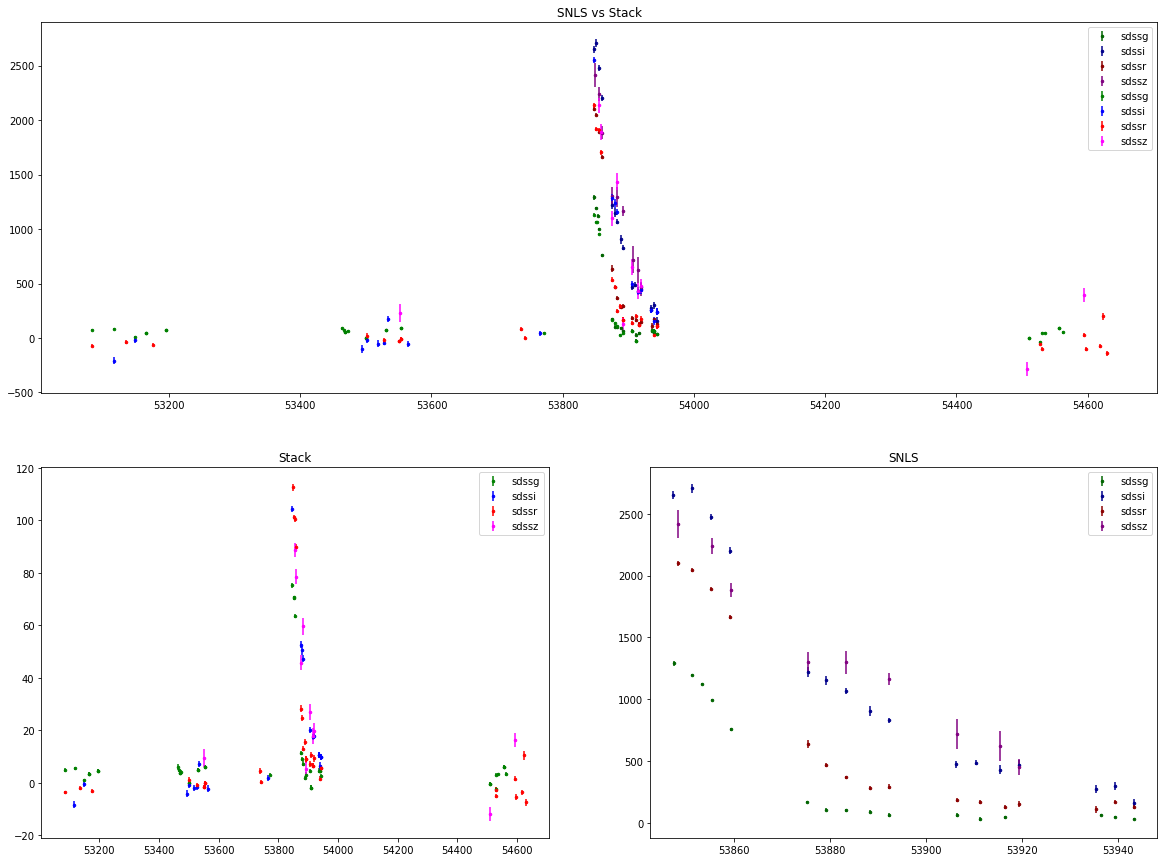

214.699262934 52.7564891549
{'sdssi': 22.555999531729469, 'sdssr': 19.492777518926584, 'sdssz': 25.293246253786105, 'sdssg': 15.046693713054104}


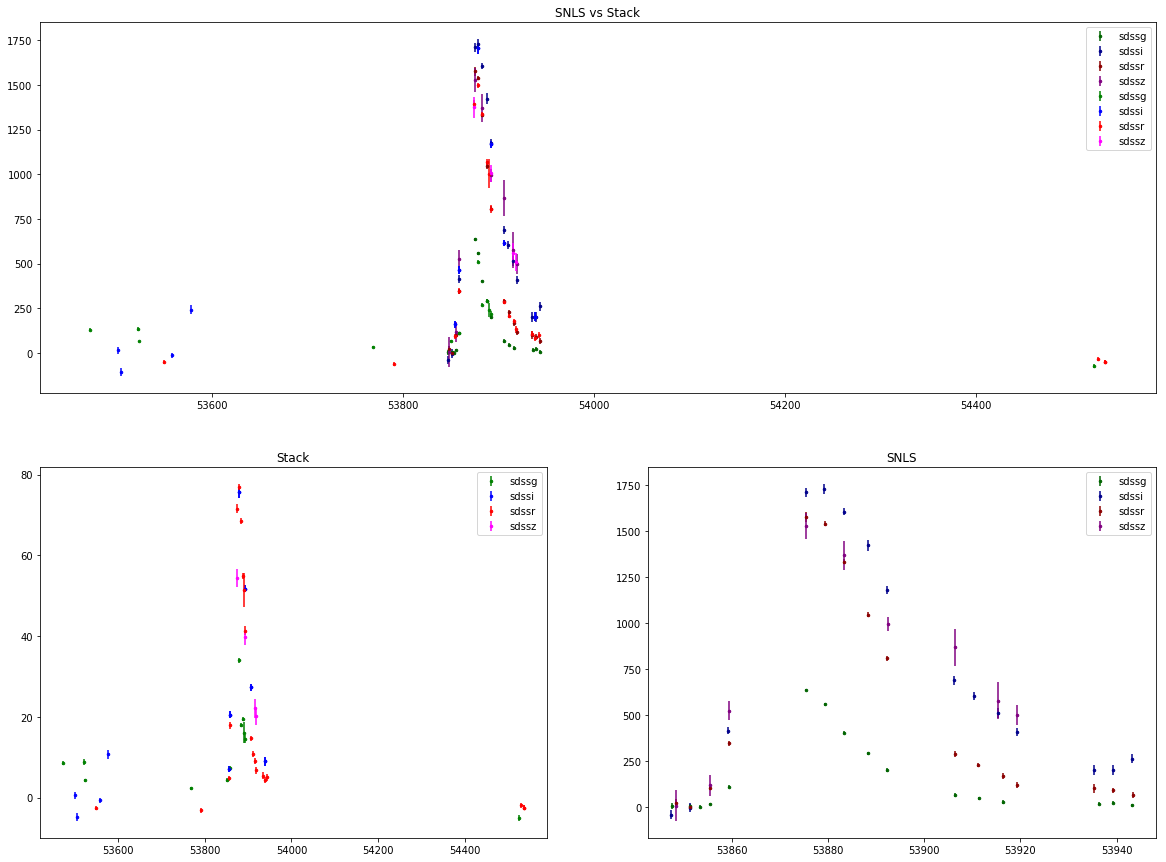

214.254449411 52.2324475585
{'sdssi': 22.407589230951416, 'sdssr': 18.331229693559369, 'sdssz': 24.539697319191134, 'sdssg': 15.865997492135572}


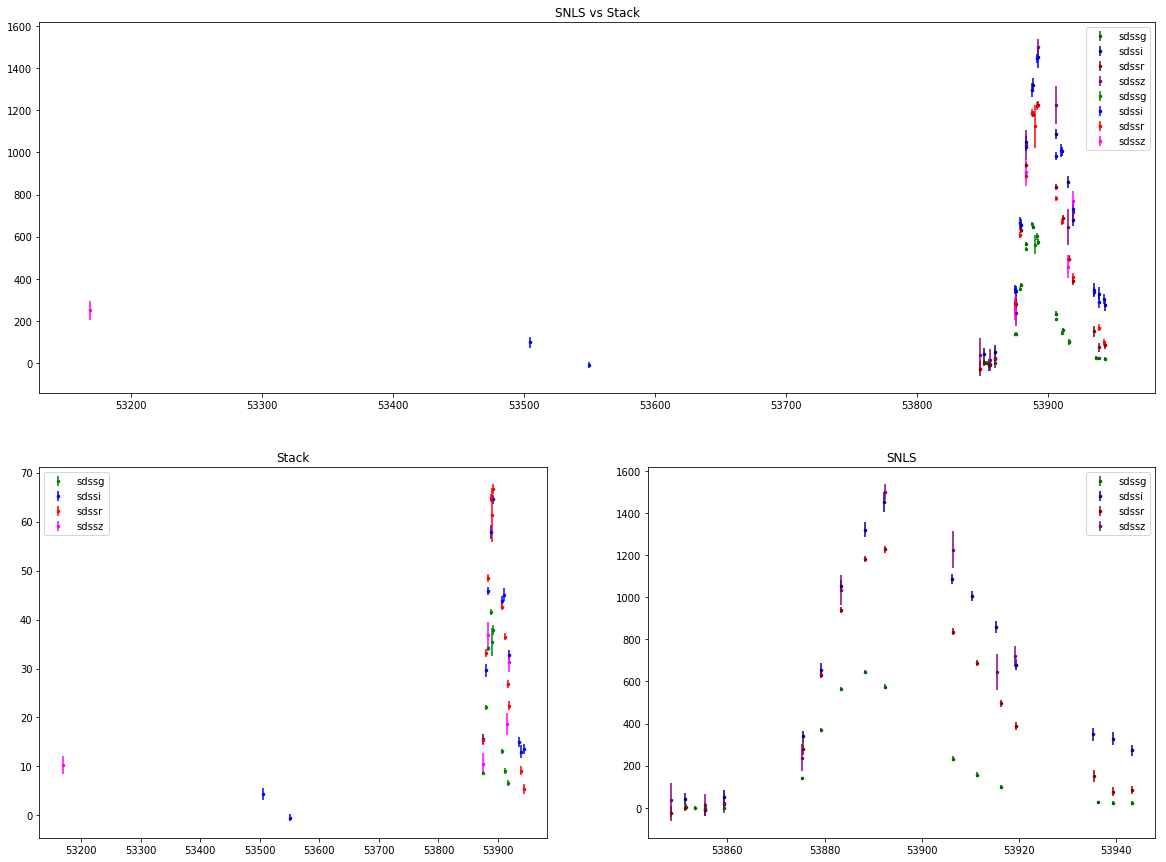

214.847679703 53.0229650379
{'sdssi': 22.847215919228073, 'sdssr': 19.625765391855502, 'sdssz': 27.022781691346101, 'sdssg': nan}


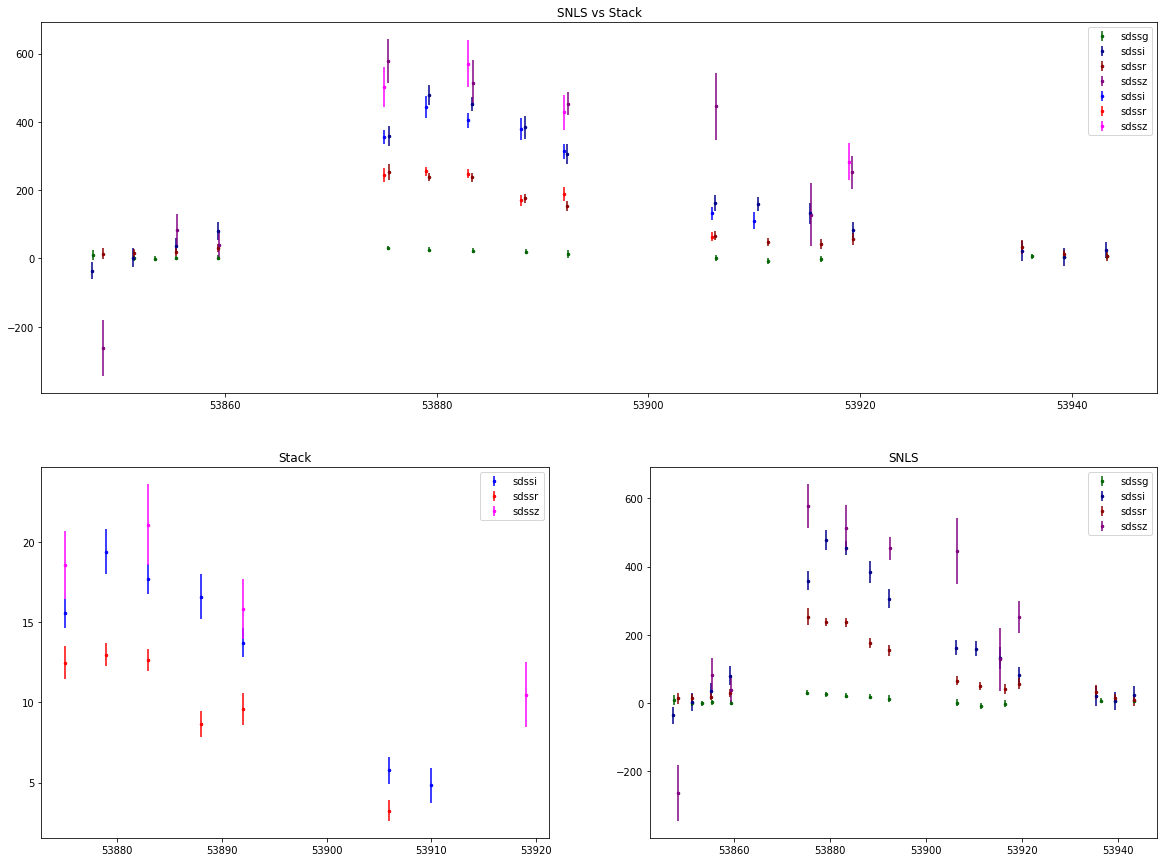

215.305481235 52.4560930921
{'sdssi': 15.827754353480938, 'sdssr': 18.555811447226191, 'sdssz': 27.694825464568069, 'sdssg': nan}


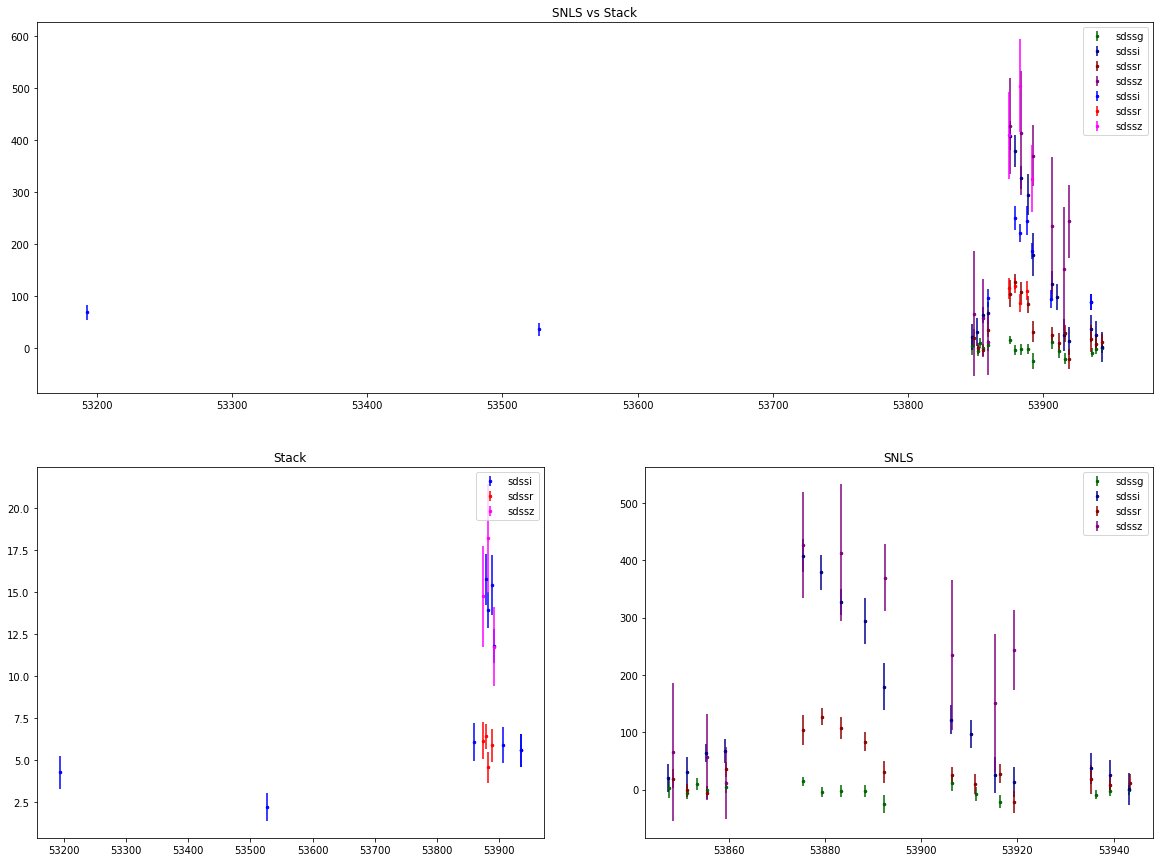

215.519700188 52.3384401707
{'sdssi': 23.77190925395, 'sdssr': 18.722437811922912, 'sdssz': 27.010798937832615, 'sdssg': 17.627465149413688}


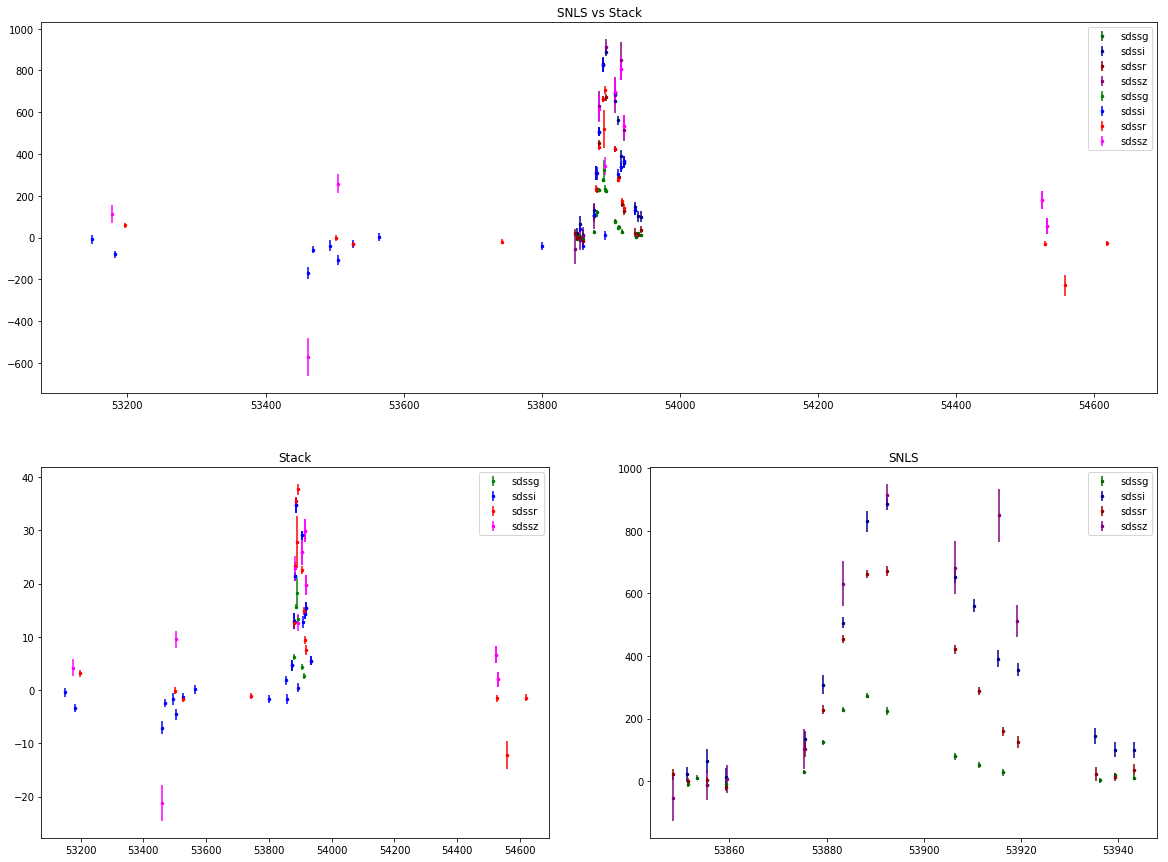

215.077556541 52.8971191949
{'sdssi': 25.190230201174785, 'sdssr': 19.611550025793491, 'sdssz': 25.928291420863317, 'sdssg': 15.591230316308057}


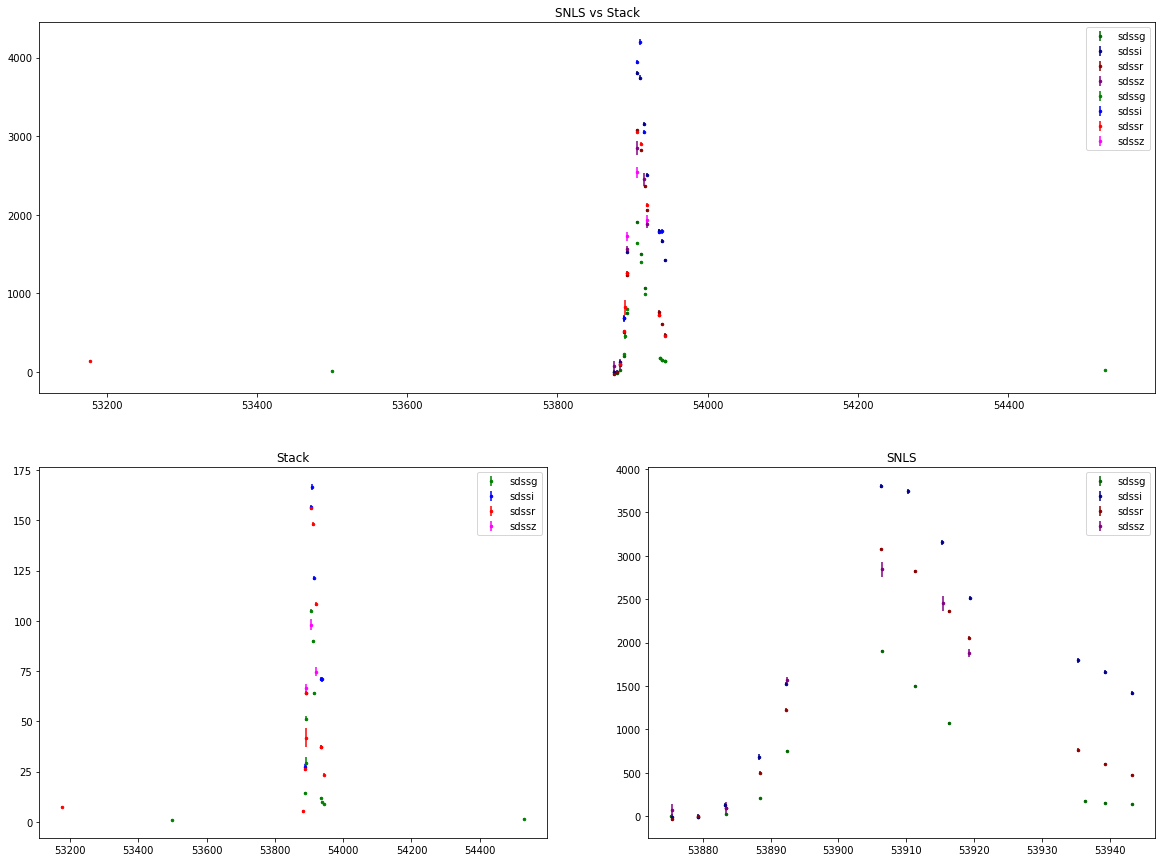

214.630797728 52.4429781183
{'sdssi': 24.869363027446582, 'sdssr': 20.329600768751057, 'sdssz': 13.068703181340009, 'sdssg': nan}


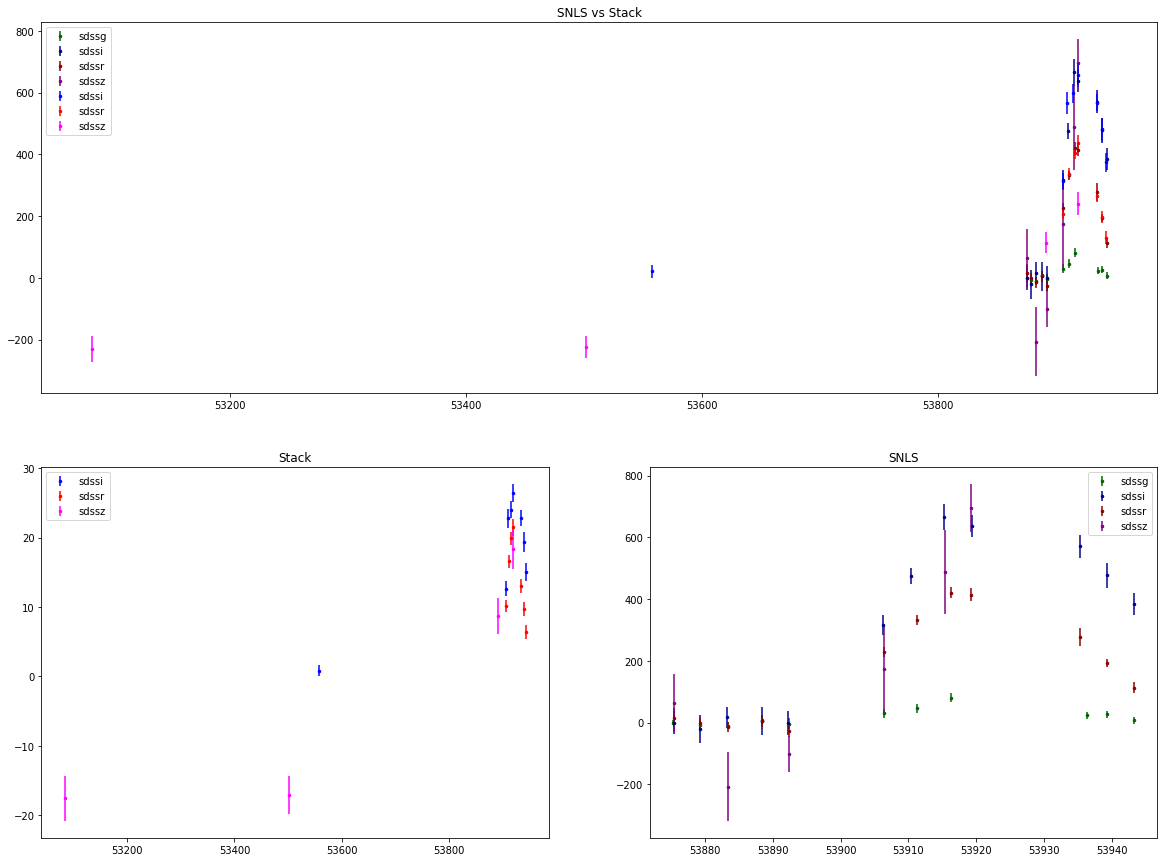

214.435884051 52.3613459074
{'sdssi': 21.693656279676116, 'sdssr': 19.845788173055116, 'sdssz': 25.731164270660315, 'sdssg': 16.633601840610229}


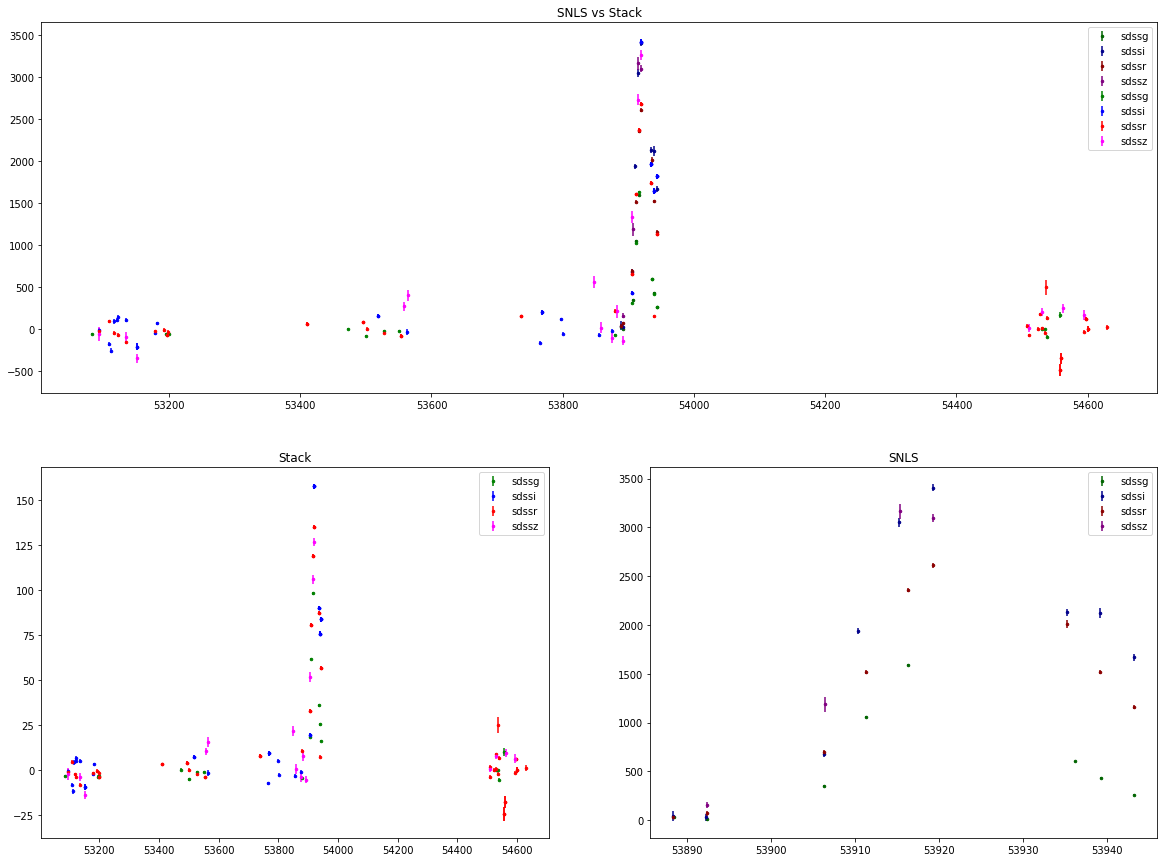

214.263491303 52.936126225
{'sdssi': 24.569695438662709, 'sdssr': 20.839371929249801, 'sdssz': nan, 'sdssg': 17.461076397772622}


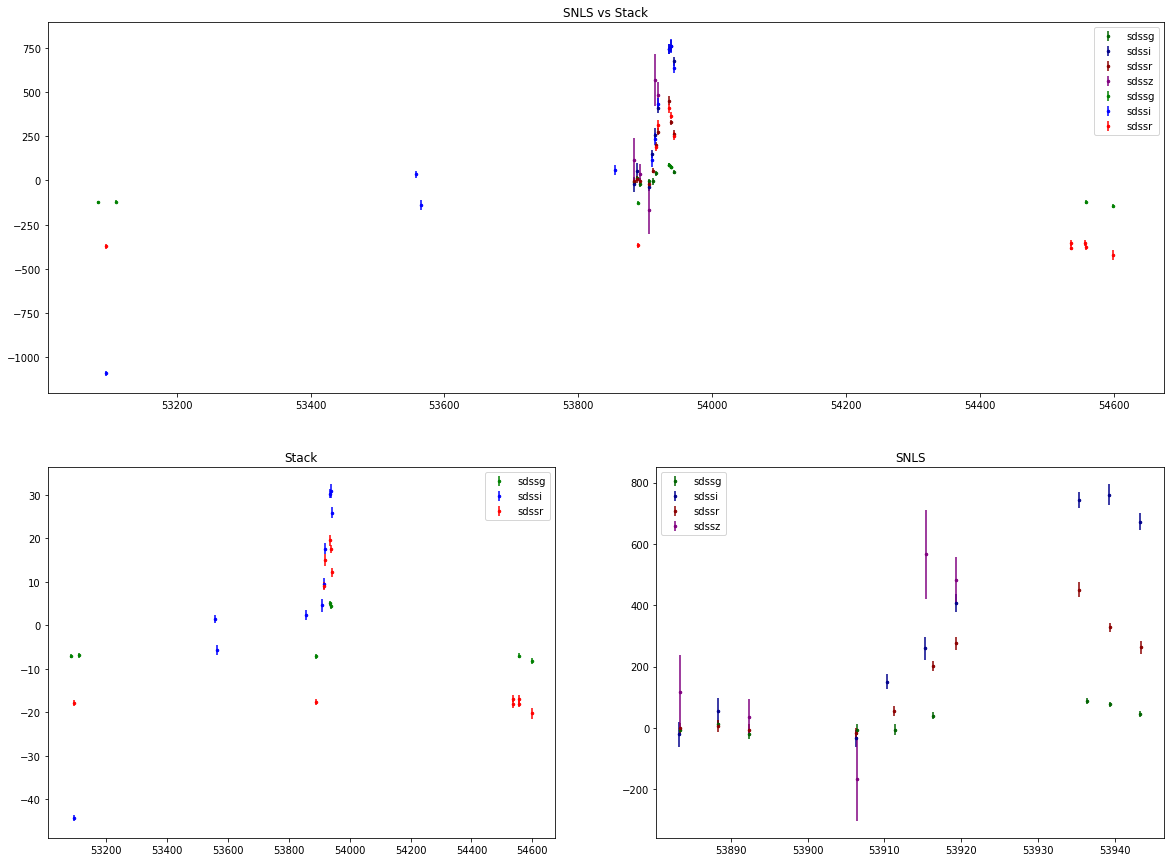

In [33]:
import astropy.coordinates as coord
coords = []
for match in matches_45:
    t = match[-1]
    

    plt.figure(figsize=(20,15))
    c = coord.SkyCoord(ra=float(np.mean(t['ra'])), dec=float(np.mean(t['dec'])), unit=(u.rad))
    print c.ra.deg, c.dec.deg
    coords.append(c)
    plt.subplot2grid((2, 2), (0, 0), colspan=2)
    
    n_factors = {}
    n_factors["sdssi"]=normalize_light_curve( match[0],t, "sdssi")
    n_factors["sdssg"]=normalize_light_curve( match[0],t, "sdssg")
    n_factors["sdssr"]=normalize_light_curve( match[0],t, "sdssr")
    n_factors["sdssz"]=normalize_light_curve( match[0],t, "sdssz")
    
    print n_factors
    
    plt.title("SNLS vs Stack")
    show_multi_filter_light_curve(match[0], snls_colors)
    show_multi_filter_light_curve(t, stack_colors, n_factors)
    
    plt.subplot2grid((2, 2), (1, 0))
    plt.title("Stack")
    #plt.xlim(xmin=53000, xmax=53250)
    show_multi_filter_light_curve(t, stack_colors)
    
    plt.subplot2grid((2, 2), (1, 1))
    plt.title("SNLS")
    show_multi_filter_light_curve(match[0], snls_colors)

    plt.show()
    

In [37]:
import astropy.coordinates as coord
import astropy.units as u

c1 = coord.SkyCoord(ra=215.099520256, dec=52.8207065675, unit=(u.deg))
c2 = coord.SkyCoord(ra=215.099758337, dec=52.8208809133, unit=(u.deg))

s1 = {'ra':c1.ra.rad,'dec':c1.dec.rad}
s2 = {'ra':c2.ra.rad,'dec':c1.dec.rad}

print DSTools.source_distance(s1,s2) 


0.857092323955


In [39]:
DATADIR="/datadec/cppm/jpreyes/CFHT_Complete"
directory = DATADIR+"/detect_testSN_2/"
butler = dafPersist.Butler(directory) 

patches = []
patches_file=open(DATADIR+"/patches.txt", "rb")
for line in patches_file:
    line = line.replace('\n','')
    text = re.split("=| ",line)
    patches.append(text[-1])
patches_file.close()

dates = []
days_file=open(DATADIR+"/days_04.txt", "rb")

for day in days_file:
    day = day.replace('\n','')
    dates.append(day)

days_file.close()
print dates

['2004-03-17', '2004-03-19', '2004-03-30', '2004-04-14', '2004-04-17', '2004-04-21', '2004-04-22', '2004-04-26', '2004-04-28', '2004-05-09', '2004-05-13', '2004-05-21', '2004-05-24', '2004-05-26', '2004-06-09', '2004-06-13', '2004-06-19', '2004-06-21', '2004-06-22', '2004-06-26', '2004-07-07', '2004-07-09', '2004-07-11', '2004-07-12', '2004-07-14']


In [47]:
date = dates[0]
patch_and_coord = []
degrees = []
for l, lc  in matches_45:
    for patch in patches:

        if butler.datasetExists("dayDiff_differenceExp", dataId={"filter":'r',"tract":0, "patch":patch, 'date':date}):
                dayDiff = butler.get("dayDiff_differenceExp", dataId={"filter":'r',"tract":0, "patch":patch, 'date':date})
                bbox = dayDiff.getBBox()
                wcs = dayDiff.getWcs()
                
                angle_ra = afwGeom.Angle(lc[0]["ra"])
                angle_dec = afwGeom.Angle(lc[0]["dec"])
                coord = wcs.skyToPixel(angle_ra, angle_dec)
                
                if bbox.contains(afwGeom.Point2I(coord)):
                    patch_and_coord.append((patch, angle_ra.asDegrees(), angle_dec.asDegrees(), np.median(lc['mjd'])))
                    #break
                    
    degrees.append(coord)

In [69]:
patch_and_coord

[('19,10', 214.4377149261246, 52.46781455679339, 53149.0),
 ('19,20', 214.45830178828786, 52.963570208763976, 53117.0),
 ('11,17', 215.0997442198318, 52.820878540836254, 53121.0),
 ('11,17', 215.09965037130732, 52.820783131362134, 53119.0),
 ('18,14', 214.55181886474597, 52.65839335129509, 53121.0),
 ('19,10', 214.45160990855345, 52.470675508458314, 53121.0),
 ('18,6', 214.54155468579816, 52.277690507542914, 53136.0),
 ('18,7', 214.54155468579816, 52.277690507542914, 53136.0),
 ('19,6', 214.44192831171546, 52.2675740753201, 53123.0),
 ('15,22', 214.78250180481274, 53.072048710246825, 53146.0),
 ('17,11', 214.60887743925102, 52.52841512943165, 53151.0),
 ('17,12', 214.60887743925102, 52.52841512943165, 53151.0),
 ('21,8', 214.2411030974021, 52.379498751462684, 53122.0),
 ('21,9', 214.2411030974021, 52.379498751462684, 53122.0),
 ('22,8', 214.2411030974021, 52.379498751462684, 53122.0),
 ('22,9', 214.2411030974021, 52.379498751462684, 53122.0),
 ('5,14', 215.63568815668043, 52.6469613608

In [67]:
def visualize(patch, date, ra, dec, exp, frame=1):
    
    dataId= {"filter":filter,"tract":0, "patch":patch, 'date':date}
    dayDiff = butler.get(exp, dataId=dataId)
    catalog = butler.get("dayDiff_class_diaSrc", dataId=dataId)
    ds9.mtv(dayDiff, frame=frame)
    ds9.setMaskTransparency(100, frame=frame)
    for source in catalog:

        ds9.dot("o", source.getX(), source.getY(), size = 25, ctype = ds9.RED, frame=frame)

    bbox = dayDiff.getBBox()
    wcs = dayDiff.getWcs()

    angle_ra = afwGeom.Angle(ra, afwGeom.degrees)
    angle_dec = afwGeom.Angle( dec , afwGeom.degrees)
    coord = wcs.skyToPixel(angle_ra, angle_dec)
    print coord
    ds9.dot("o", coord.getX(), coord.getY(), size = 20, ctype = ds9.BLUE, frame=frame)

In [82]:
pa = '11,17'
ra = 215.0997442198318
dec = 52.820878540836254
filter='i'
#exp = "dayCoadd"
exp = "dayDiff_differenceExp"

visualize(pa, '2004-04-22', ra , dec , exp, frame = 1)
#visualize('19,21', '2004-03-30', ra, dec,exp, frame = 2)
#visualize('20,20', '2004-03-30', ra, dec,exp, frame = 3)
#visualize('20,21', '2004-03-30', ra, dec,exp, frame = 4)

(11888, 17608)


In [95]:
cls = []
for lc in lcs:
    cls.extend(lc['classification'].tolist())

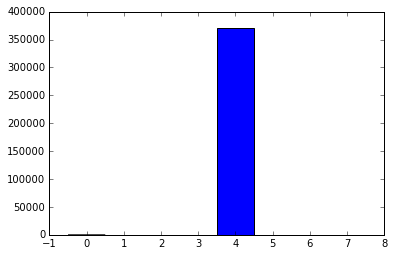

In [96]:
plt.hist(cls, bins=8,  align='left', range=(0,8))
plt.show()

In [111]:
len(lcs)

56620

In [117]:
std_ra = []
std_dec = []

for i, lc in enumerate(lcs):
    print i
    c = coord.SkyCoord(np.mean(lc["ra"]),np.mean(lc["dec"]), unit=( u.rad))
    std_ra.append(c.ra.deg)
    std_dec.append(c.dec.deg)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128


KeyboardInterrupt: 

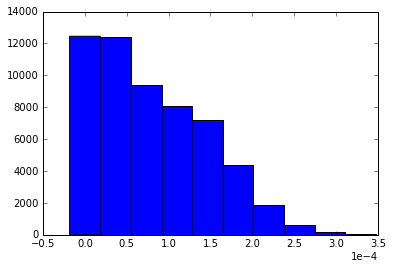

In [116]:
plt.hist(std_ra,  align='left')
plt.ticklabel_format(style='sci', axis='x',scilimits=(0,0))

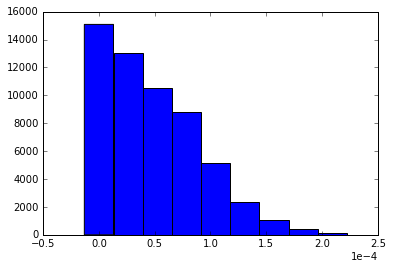

In [115]:
plt.hist(std_dec,  align='left')
plt.ticklabel_format(style='sci', axis='x',scilimits=(0,0))

In [106]:
c = coord.SkyCoord(np.std(lc["ra"]),np.std(lc["dec"]), unit=( u.rad))

In [109]:
c.ra.deg
c.dec.deg

6.952698350072601e-05